In [7]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input,Dense,Reshape,Flatten,Dropout
from tensorflow.keras.layers import BatchNormalization,Activation,LeakyReLU,UpSampling2D,Conv2D
from tensorflow.keras.models import Sequential, Model
import numpy as np
import matplotlib.pyplot as plt

In [13]:
# 생성자 모델 만들기
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
# 128은 임의로 정한 노드의 수, input_dim은 100차원 크기의 랜덤 벡터를 집어넣으라는 뜻
# 7*7은 이미지의 최초 크기를 말함
generator.add(BatchNormalization())
generator.add(Reshape((7,7,128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same',activation='tanh'))

In [14]:
# 판별자 모델 만들기
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128,kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable=False

In [42]:
# 생성자와 판별자 모델을 연결시키는 gan모델 만들기 
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan= Model(ginput,dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

#신경망을 실행시키는 함수 만들기 

    


# MNIST데이터 불러오기
# 앞서 불러온 MNIST다시 이용. 테스트 과정은 필요없고 이미지만 사용할 것이기 때문에 X_trian만 호출
def gan_train(epoch, batch_size, saving_interval):
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train.reshape(X_train.shape[0],28,28,1).astype('float32')
# 127.5를 빼준 뒤 127.5로 나눠서 -1 ~ 1사이의 값으로 바꿈
    X_train = (X_train - 127.5) / 127.5
    true = np.ones((batch_size,1))
    fake = np.zeros((batch_size,1))

    for i in range(epoch):
        # 실제 데이터를 판별자에 입력
        idx = np.random.randint(0,X_train.shape[0], batch_size)
        imgs = X_train[idx]
        d_loss_real = discriminator.train_on_batch(imgs,true)

        # 가상 이미지를 판별자에 입력
        noise = np.random.normal(0,1, (batch_size,100))
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs,fake)

        # 판별자와 생성자의 오차 계산
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        g_loss = gan.train_on_batch(noise,true)

        print('epoch: %d' % i, 'd_loss:%.4f' % d_loss, 'g_loss:%.4f' % g_loss)

        # 중간 과정을 이미지로 저장하는 부분. 정해진 인터벌 만큼 학습되면 그때 만든 이미지를 gan_images폴더에 
        if i % saving_interval == 0:
            # r,c=5.5
            noise = np.random.normal(0,1,(25,100))
            gen_imgs = generator.predict(noise)

            # Rescale images 0-1
            gen_imgs = 0.5 * gen_imgs + 0.5

            fig, axs = plt.subplots(5,5)
            count = 0
            for j in range(5):
                for k in range(5):
                    axs[j,k].imshow(gen_imgs[count, :,:,0], cmap='gray')
                    axs[j,k].axis('off')
                    count += 1
                    fig.savefig("gan_images/gan_mnist_%d.png"%i)

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 100)]             0         
                                                                 
 sequential_8 (Sequential)   (None, 28, 28, 1)         865281    
                                                                 
 sequential_9 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


1/1 [==============================] - 0s 119ms/step
epoch: 0 d_loss:0.4931 g_loss:0.0608
1/1 [==============================] - 0s 39ms/step
epoch: 1 d_loss:0.5256 g_loss:0.1494
1/1 [==============================] - 0s 43ms/step
epoch: 2 d_loss:0.4764 g_loss:0.4833
1/1 [==============================] - 0s 48ms/step
epoch: 3 d_loss:0.4293 g_loss:0.9894
1/1 [==============================] - 0s 53ms/step
epoch: 4 d_loss:0.4764 g_loss:1.1096
1/1 [==============================] - 0s 139ms/step
epoch: 5 d_loss:0.5031 g_loss:0.9421
1/1 [==============================] - 0s 129ms/step
epoch: 6 d_loss:0.5766 g_loss:0.6467
1/1 [==============================] - 0s 48ms/step
epoch: 7 d_loss:0.5821 g_loss:0.4109
1/1 [==============================] - 0s 68ms/step
epoch: 8 d_loss:0.5779 g_loss:0.3100
1/1 [==============================] - 0s 44ms/step
epoch: 9 d_loss:0.5470 g_loss:0.3152
1/1 [==============================] - 0s 47ms/step
epoch: 10 d_loss:0.5245 g_loss:0.3818
1/1 [============

C:\Users\user\AppData\Local\Temp\ipykernel_37168\3043769392.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(5,5)


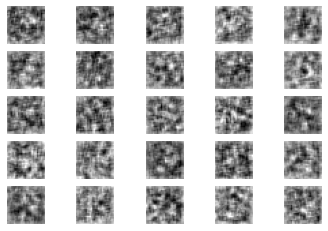

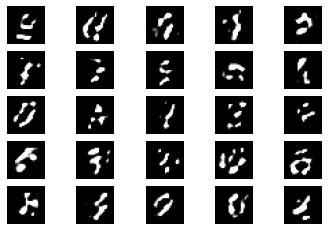

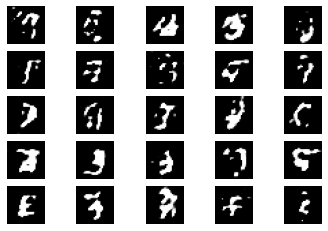

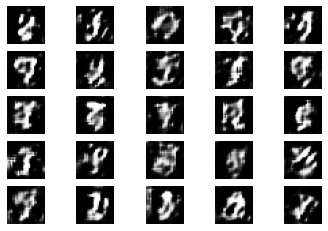

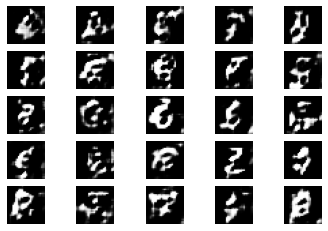

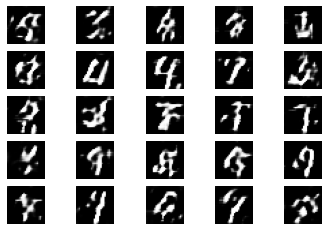

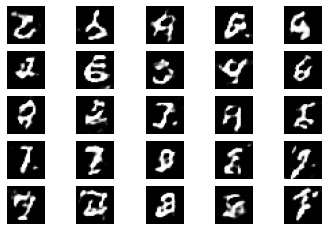

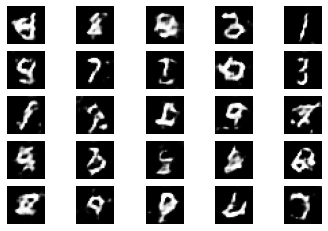

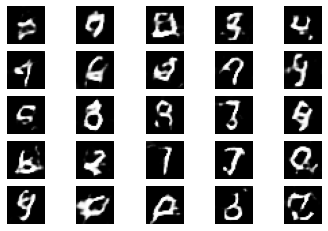

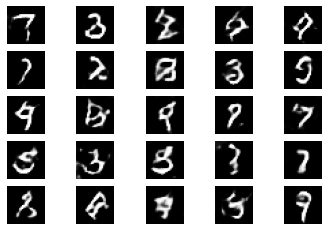

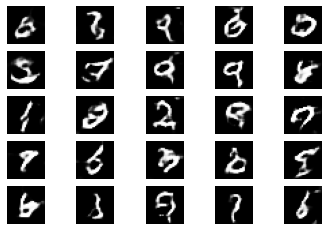

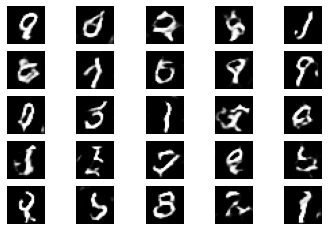

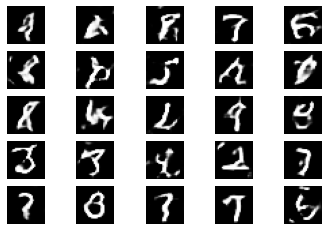

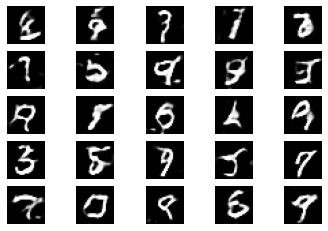

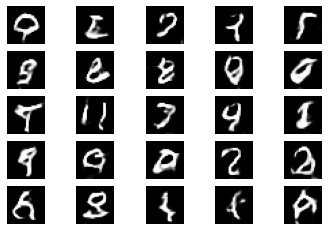

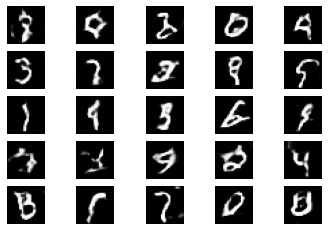

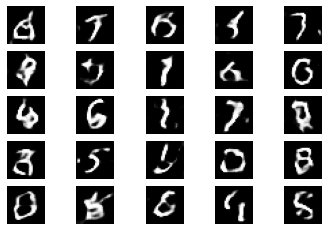

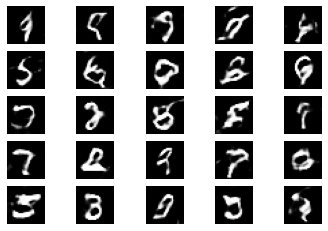

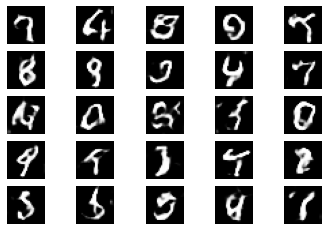

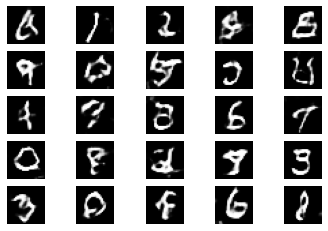

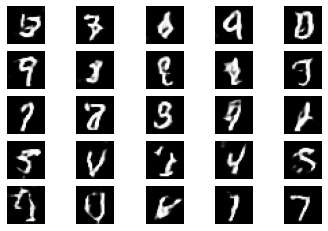

In [43]:


#4000번 반복되고 (+1을 하는 것에 주의)배치 크기는 32, 200번마다 결과가 저장됨
gan_train(4001, 32, 200)